In [1]:
import spectral as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

sys.path.append('../')
from preprocessing import *
from plotting_parameters import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.use("wxAgg")
%matplotlib inline
set_plotting_style("latex")
# set_plotting_style("default")

Load image

c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


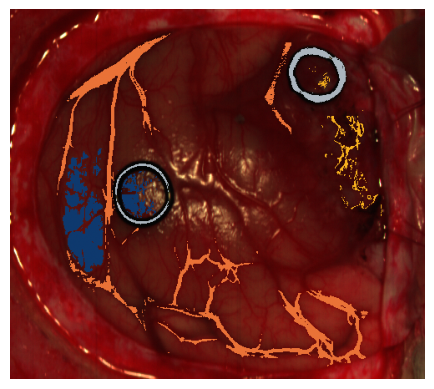

In [2]:
data_folder = "../../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Hypervascularized", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

# Estimation of reflectance and emission
R = np.subtract(img.asarray(), dark_ref.asarray(), dtype=np.float32)
E = np.subtract(white_ref.asarray(), dark_ref.asarray(), dtype=np.float32).squeeze()

# plot the image
# fig = plot_img(img, legend=False)
# plt.savefig('../../figures/helicoid_12_01_rgb.png',bbox_inches='tight',pad_inches=0,format='png')
fig = plot_img(img, gt_map, class_labels, class_colors, legend=False)
# plt.savefig('../../figures/helicoid_12_01_rgb_masked.png',bbox_inches='tight',pad_inches=0,format='png')

# # plot the image as a hypercube
# img = img.load()
# vmax = np.percentile(img, 99.9)
# img = np.clip(img, 0, vmax)
# sp.view_cube(img, bands=[425,192,109], background=(1,1,1))


### Subspace Projection tests

Analize noise of projected spectra


Text(0.5, 0.98, 'White Reference')

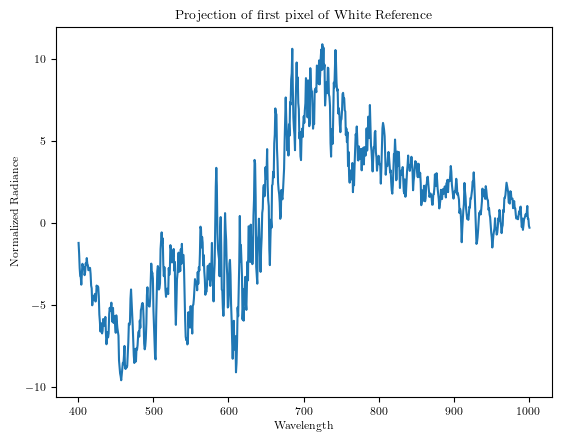

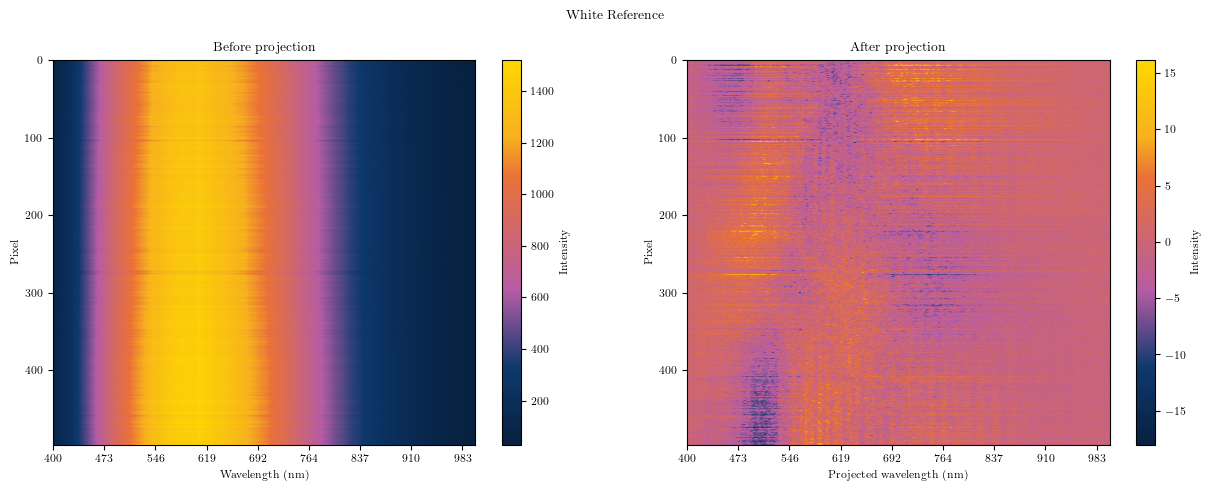

In [4]:
band_centers = img.bands.centers

# E, band_centers = band_removal(E, [450,900], orig_bands=img.bands.centers)

# smooth and average estimated emission to minimize noise
E = smooth_spectral(E, 5)
E_mean = np.mean(E, axis=0, dtype=np.float32)

# get mapping to subspace orthogonal to E
P_E = np.eye(E_mean.shape[0]) - np.outer(E_mean, E_mean)/np.dot(E_mean, E_mean)

# project white reference onto subspace orthogonal to E
E_proj = np.einsum('ij,kj->ki', P_E, E)

# plt.figure()
# plt.imshow(P_E, cmap='viridis', aspect='equal')
# cb = plt.colorbar()
# plt.title('Projection Matrix')

plt.figure()
plt.plot(band_centers, P_E @ E[0,:])
plt.title('Projection of first pixel of White Reference')
plt.xlabel('Wavelength')
plt.ylabel('Normalized Radiance')

# Plot white reference as image
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
im0 = axs[0].imshow(E, cmap=tum_cmap, aspect='auto')  # 'viridis' is just an example colormap; you can choose others
cb0 = plt.colorbar(im0)
cb0.set_label('Intensity')
axs[0].set_xticks(np.arange(0,E.shape[1],100))  # Set ticks to pixel numbers
axs[0].set_xticklabels([f'{wavelength:.0f}' for wavelength in band_centers[::100]])
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_ylabel('Pixel')
axs[0].set_title('Before projection')

im1 = axs[1].imshow(E_proj, cmap=tum_cmap, aspect='auto')
cb1 = plt.colorbar(im1, ax=axs[1])
cb1.set_label('Intensity')
axs[1].set_xticks(np.arange(0,E_proj.shape[1],100))  # Set ticks to pixel numbers
axs[1].set_xticklabels([f'{wavelength:.0f}' for wavelength in band_centers[::100]])
axs[1].set_xlabel('Projected wavelength (nm)')
axs[1].set_ylabel('Pixel')
axs[1].set_title('After projection')
fig.suptitle('White Reference')

Visualize spectrum component parallel to emission spectrum


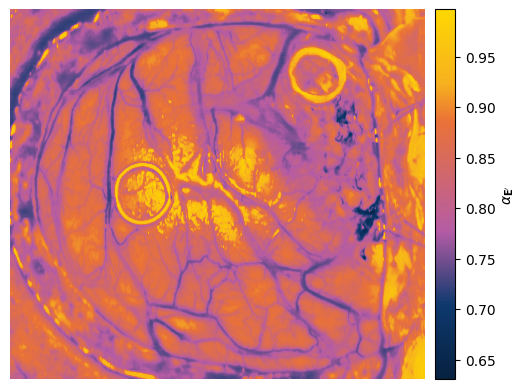

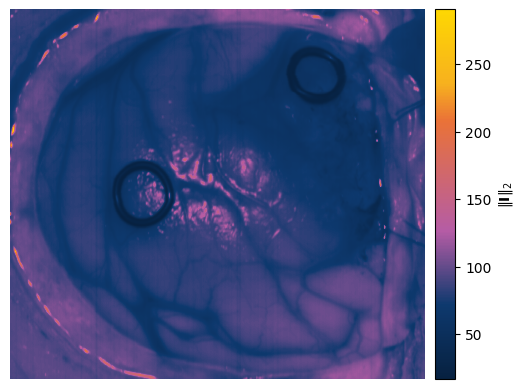

In [4]:
alpha_E = np.einsum('ijk,k->ij', R, E_mean) / (np.linalg.norm(E_mean) * np.linalg.norm(R, axis=2))

# magnitude in the direction of E
fig, ax = plt.subplots()
image = ax.imshow(alpha_E, cmap=tum_cmap, aspect='equal')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(image, cax=cax, label=r"$\alpha_{\mathbf{E}'}$")
# save figure as svg
# plt.savefig("../figures/magnitude_of_E_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# total magnitude
img_norm = np.sqrt(np.linalg.norm(R, axis=2, ord=2))
fig, ax = plt.subplots()
image = ax.imshow(img_norm, cmap=tum_cmap, aspect='equal')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(image, cax=cax, label=r"$\|\mathbf{I}\|_2$")

# comment: almost all of the light reflected from the rings is specular, which makes sense since they are black, so they have very little diffuse reflection
# also there are scanning lines in the image due to lighting changes?

### Comparison plots before and after preprocessing

load projected image and perform normalizations for later plots

In [3]:
# raw image
img_raw = img.asarray()

# calibrated image
img_calib = calibrate_img(img, white_ref, dark_ref)
img_calib_norm = img_calib/np.linalg.norm(img_calib, axis=-1, ord=1, keepdims=True)
img_calib_norm_smooth = smooth_spectral(img_calib_norm, 5)
img_absorbance = -np.log(img_calib_norm_smooth)

# projected image
# R_E = np.load(f"{data_folder}/results/R_E.npy")
img_proj = project_img(img_raw, white_ref, dark_ref)
img_proj_norm = img_proj/np.linalg.norm(img_proj, axis=2, ord=1, keepdims=True)

# get band centers
band_centers = img.bands.centers


# img_raw, _ = band_removal(img_raw, [450.0, 900.0], img.bands.centers)
# img_calib, band_centers = band_removal(img_calib, [450.0, 900.0], img.bands.centers)
# img_calib_norm, _ = band_removal(img_calib_norm, [450.0, 900.0], img.bands.centers)
# R_E, _= band_removal(R_E, [450.0, 900.0], img.bands.centers)
# R_E_norm, _ = band_removal(R_E_norm, [450.0, 900.0], img.bands.centers)
# img_raw = smooth_spectral(img_raw, 5)

C:\Users\User\AppData\Local\Temp\ipykernel_13176\3187641682.py:8: RuntimeWarning: divide by zero encountered in log
  img_absorbance = -np.log(img_calib_norm_smooth)
C:\Users\User\AppData\Local\Temp\ipykernel_13176\3187641682.py:8: RuntimeWarning: invalid value encountered in log
  img_absorbance = -np.log(img_calib_norm_smooth)


Plot examplary spectra from image before and after preprocessing

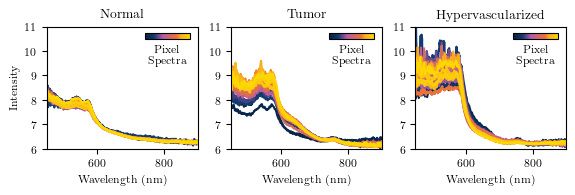

In [5]:
nspectra = 20

# plot raw spectra
# fig, axs = plot_class_spectra(img_raw, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2))
# # fig.suptitle('Pixel spectra of raw image')
# axs[0].set_ylabel('Intensity')
# axs[0].set_xlim([450, 900])
# axs[0].set_ylim([0, 700])
# axs[1].set_xlim([450, 900])
# axs[1].set_ylim([0, 700])
# axs[2].set_xlim([450, 900])
# axs[2].set_ylim([0, 700])
# plt.tight_layout()
# # plt.savefig("../../figures/raw_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')
# # plt.savefig("../../presentation/raw.svg", format='svg', bbox_inches='tight')

# # # plot calibrated spectra
# fig, axs = plot_class_spectra(img_calib, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2))
# # fig.suptitle('Pixel spectra of calibrated image')
# axs[0].set_ylabel('Intensity')
# axs[0].set_xlim([450, 900])
# axs[0].set_ylim([0, 0.7])
# axs[1].set_xlim([450, 900])
# axs[1].set_ylim([0, 0.7])
# axs[2].set_xlim([450, 900])
# axs[2].set_ylim([0, 0.7])
# plt.tight_layout()
# # plt.savefig("../../figures/calib_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')
# # plt.savefig("../../presentation/calib.svg", format='svg', bbox_inches='tight')

# # plot calibrated + normalized spectra
# fig, axs = plot_class_spectra(img_calib_norm, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2))
# # fig.suptitle('Pixel spectra of calibrated and normalized image')
# axs[0].set_ylabel('Intensity')
# axs[0].set_xlim([450, 900])
# axs[0].set_ylim([0, 0.003])
# axs[1].set_xlim([450, 900])
# axs[1].set_ylim([0, 0.003])
# axs[2].set_xlim([450, 900])
# axs[2].set_ylim([0, 0.003])
# plt.tight_layout()
# # plt.savefig("../../figures/calib_norm_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')
# # plt.savefig("../../presentation/calib_norm.svg", format='svg', bbox_inches='tight')

# # plot calibrated + normalized + smoothed
# fig, axs = plot_class_spectra(img_calib_norm_smooth, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2))
# # fig.suptitle('Pixel spectra of calibrated and normalized image')
# axs[0].set_ylabel('Intensity')
# axs[0].set_xlim([450, 900])
# axs[0].set_ylim([0, 0.003])
# axs[1].set_xlim([450, 900])
# axs[1].set_ylim([0, 0.003])
# axs[2].set_xlim([450, 900])
# axs[2].set_ylim([0, 0.003])
# plt.tight_layout()
# # plt.savefig("../../figures/calib_norm_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')
# # plt.savefig("../../presentation/calib_norm_smooth.svg", format='svg', bbox_inches='tight')

# plot absorbance
fig, axs = plot_class_spectra(img_absorbance, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2), legend_loc='upper right')
# fig.suptitle('Pixel spectra of absorbance')
axs[0].set_ylabel('Intensity')
axs[0].set_xlim([450, 900])
axs[0].set_ylim([6, 11])
axs[1].set_xlim([450, 900])
axs[1].set_ylim([6, 11])
axs[2].set_xlim([450, 900])
axs[2].set_ylim([6, 11])
plt.tight_layout()
# plt.savefig("../../figures/absorbance_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')
# plt.savefig("../../presentation/absorbance.svg", format='svg', bbox_inches='tight')

# # plot projected spectra
# fig, axs = plot_class_spectra(img_proj, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2))
# # fig.suptitle('Pixel spectra of projected image')
# axs[0].set_ylabel('Intensity')
# plt.tight_layout()
# # plt.savefig("../../figures/proj_norm_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# # plot projected and normalized spectra
# fig, axs = plot_class_spectra(img_proj_norm, gt_map, nspectr=nspectra, bands=band_centers, figsize=(5.8,2))
# # fig.suptitle('Pixel spectra of projected and normalized image')
# axs[0].set_ylabel('Intensity')
# plt.tight_layout()
# # plt.savefig("../../figures/proj_norm_image_spectra_helicoid_12-01.svg", format='svg', bbox_inches='tight')


In [12]:
def plot_class_dist(img, gt_map, bands, class_ids, class_labels, class_colors, figsize=(5,4), legend_loc='upper left'):
    '''
    Plot the spectral mean and std of the specified classes.
    input:
        img: image to plot, SpyFile or array-like
        gt_map: ground truth map, np.array or SpyFile
        bands: band centers, list of floats
        class_ids: class ids to plot, list of ints
        class_labels: class names, list of strings
        class_colors: colors to use for plotting, list of strings
        figsize: figure size, tuple of floats
        legend_loc: location of the legend, string or None if no legend should be plotted
    output:
        fig: figure handle to the plot
        ax: axis handle to the plot
    '''
    img = get_array(img)
    gt_map = gt_map.asarray()

    fig, ax = plt.subplots(figsize=figsize)
    for class_id in class_ids:
        mask = np.where(gt_map[:, :, 0] == class_id)
        class_std = np.std(img[mask], axis=0)
        class_mean = np.mean(img[mask], axis=0)
        ax.plot(bands, class_mean, label=class_labels[class_id], color=class_colors[class_id])
        ax.fill_between(bands, class_mean - class_std, class_mean + class_std, alpha=0.25, color=class_colors[class_id])
    ax.set_xlim([400, 1000])
    ax.set_ylabel('Intensity')
    ax.set_xlabel('Wavelength (nm)')
    if legend_loc is not None:
        # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.3)
        order = [0,2,1]
        handles, labels = plt.gca().get_legend_handles_labels()
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=legend_loc, handlelength=0.8, borderaxespad=0.3)
        # ax.legend(loc=legend_loc, handlelength=0.8, borderaxespad=0.3)
    return fig, ax

Plot class-wise mean spectra and bands from image before and after preprocessing

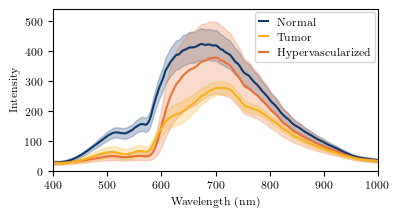

In [30]:
# plot mean raw spectra
fig, ax = plot_class_dist(img, gt_map, band_centers, [1,3,2], class_labels, class_colors, figsize=(4.2,2.1), legend_loc='upper right')
ax.set_ylim([0, 540])
# fig.suptitle('Mean pixel spectra of raw image')
plt.savefig("../../figures/raw_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# # plot mean calibrated spectra
# fig, ax = plot_class_dist(img_calib, gt_map, band_centers, [1,3,2], class_labels, class_colors)#, figsize=(2.7,2), legend_loc='upper left')
# fig.suptitle('Mean pixel spectra of calibrated image')
# # plt.savefig("../figures/calib_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# # plot mean calibrated and normalized spectra
# fig, ax = plot_class_dist(img_calib_norm, gt_map, band_centers, [1,3,2], class_labels, class_colors)#, figsize=(2.7,2), legend_loc='upper left')
# fig.suptitle('Mean pixel spectra of calibrated and normalized image')
# # plt.savefig("../figures/calib_norm_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# # plot mean projected spectra
# fig, ax = plot_class_dist(R_E, gt_map, band_centers, [1,3,2], class_labels, class_colors)#, figsize=(2.7,2), legend_loc='upper left')
# fig.suptitle('Mean pixel spectra of projected image')
# # plt.savefig("../figures/proj_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# # plot mean projected and normalized spectra
# fig, ax = plot_class_dist(R_E_norm, gt_map, band_centers, [1,3,2], class_labels, class_colors)#, figsize=(2.7,2), legend_loc='upper left')
# fig.suptitle('Mean pixel spectra of projected and normalized image')
# # plt.savefig("../figures/proj_norm_class_dist_helicoid_12-01.svg", format='svg', bbox_inches='tight')



Plot examplary bands from image before and after preprocessing

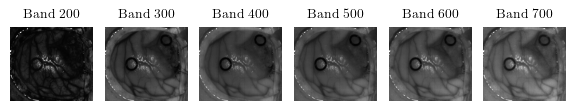

In [28]:
# plot raw image for different bands
fig, axs = plot_bands(img.asarray(), figsize=(5.8,2))
# fig.suptitle('Raw image for different bands')
plt.tight_layout()
# plt.savefig("../../figures/raw_bands_images_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# # plot calibrated image for different bands
# fig, axs = plot_bands(img_calib)#, figsize=(7.2,1))
# fig.suptitle('Calibrated image for different bands')
# plt.tight_layout()
# # plt.savefig("../figures/calib_bands_images_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# # plot calibrated image for different bands
# fig, axs = plot_bands(img_calib_norm)#, figsize=(7.2,1))
# fig.suptitle('Calibrated and normalized image for different bands')
# plt.tight_layout()
# # plt.savefig("../figures/calib_norm_bands_images_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# # plot projected image for different bands
# fig, axs = plot_bands(R_E)#, figsize=(7.2,1))
# fig.suptitle('Projected image for different bands')
# plt.tight_layout()
# # plt.savefig("../figures/proj_bands_images_helicoid_12-01.svg", format='svg', bbox_inches='tight')

# # plot projected and normalized image for different bands
# fig, axs = plot_bands(R_E_norm)#, figsize=(7.2,1))
# fig.suptitle('Projected and normalized image for different bands')
# plt.tight_layout()
# # plt.savefig("../figures/proj_bands_images_helicoid_12-01.svg", format='svg', bbox_inches='tight')


#### Per-class distribution of multiple images

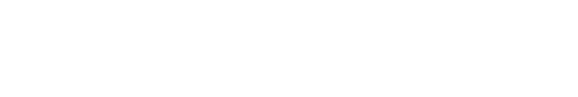

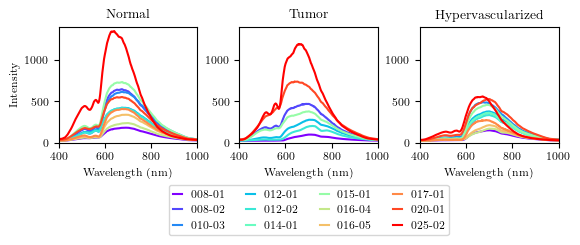

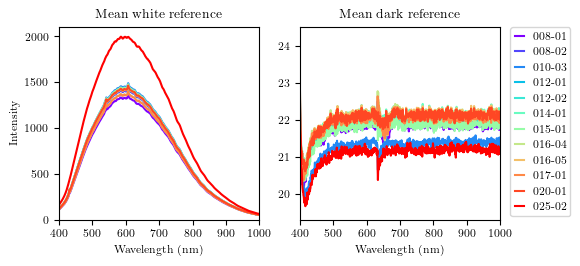

In [220]:
class_labels = ["Not labled", "Normal", "Tumor", "Hypervasculized", "Background"]
data_folder = "../../datasets/helicoid/"
gradeIVpatients = ["008-01", "008-02", "010-03", "012-01", "012-02", "014-01", "015-01", "016-04", "016-05", "017-01", "020-01", "025-02"] 
class_ids = [1, 2, 3]

colors = mpl.cm.rainbow(np.linspace(0, 1, len(gradeIVpatients)))
# colors = tum_cmap(np.linspace(0, 1, len(gradeIVpatients)))


# fig0, axs0 = plt.subplots(1, len(class_ids), figsize=(18,5))
# fig1, axs1 = plt.subplots(1, len(class_ids), figsize=(18,5))
plot_ref_full()
fig2, axs2 = plt.subplots(1, len(class_ids), figsize=(6.45,1.5))
# fig3, axs3 = plt.subplots(1, len(class_ids), figsize=(18,5))
# fig4, axs4 = plt.subplots(1, len(class_ids), figsize=(18,5))
fig_white_dark, axs_white_dark = plt.subplots(1,2, figsize=(5.7,2.5))

for n, patient in enumerate(gradeIVpatients):
    
    patient_folder = data_folder + patient + "/"
    img = sp.open_image(patient_folder + "/raw.hdr")
    white_ref = sp.open_image(patient_folder + "/whiteReference.hdr")
    dark_ref = sp.open_image(patient_folder + "/darkReference.hdr")
    gt_map = sp.open_image(patient_folder + "/gtMap.hdr")
    # img_proj = project_img(img.asarray(), white_ref, dark_ref)
    # img_proj_norm = img_proj/np.linalg.norm(img_proj, axis=2, ord=1, keepdims=True)
    
    # img_processed = calibrate_img(img, white_ref, dark_ref)
    # img_processed, band_centers = band_removal(img_processed, [450.0, 900.0], img.bands.centers)
    # img_processed = smooth_spectral(img_processed)
    # img_processed = normalize_spectral_interval(img_processed)
    # img_norm = normalize_spectral_interval_mean(img_processed, class_wise=True, gt_map=gt_map)
    # img_processed_advanced = calibrate_img_advanced(img, white_ref, dark_ref, average_ref_pixels=True)
    # img_processed_advanced, _ = band_removal(img_processed_advanced, [450.0, 900.0], img.bands.centers)


    # plot mean spectra (processed and raw) for each class
    for i, class_id in enumerate(class_ids):
        mask = np.where(gt_map.asarray()[:,:,0] == class_id)
        if len(mask[0]) == 0: 
            # axs0[i].plot([], [], color=colors[n], label=patient) # Plot an empty line to consume a color
            # axs1[i].plot([], [], color=colors[n], label=patient)  
            axs2[i].plot([], [], color=colors[n], label=patient)
            # axs3[i].plot([], [], color=colors[n], label=patient)
            # axs4[i].plot([], [], color=colors[n], label=patient)
            continue
        # axs0[i].plot(img.bands.centers, np.mean(img_processed_advanced[mask], axis=0), color=colors[n], label=patient)
        # axs1[i].plot(img.bands.centers, np.mean(img_processed[mask], axis=0), color=colors[n], label=patient)
        axs2[i].plot(img.bands.centers, np.mean(img.asarray()[mask], axis=0), color=colors[n], label=patient)
        # axs3[i].plot(img.bands.centers, np.mean(img_proj[mask], axis=0), color=colors[n], label=patient)
        # axs4[i].plot(img.bands.centers, np.mean(img_proj_norm[mask], axis=0), color=colors[n], label=patient)
        
    # plot white and dark references for patient
    axs_white_dark[0].plot(img.bands.centers, np.mean(white_ref.asarray(), axis=(0,1)), color=colors[n], label=patient)
    axs_white_dark[1].plot(img.bands.centers, np.mean(dark_ref.asarray(), axis=(0,1)), color=colors[n], label=patient)

# fig0.suptitle("Normalized (Advanced normalization)")
# axs0[0].set_title("Normal")
# axs0[1].set_title("Tumor")
# axs0[2].set_title("Hypervascularized")
# axs0[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

# fig1.suptitle("Normalized (Standard normalization))")
# axs1[0].set_title("Normal")
# axs1[1].set_title("Tumor")
# axs1[2].set_title("Hypervascularized")
# axs1[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

# fig2.suptitle("Raw")
axs2[0].set_title("Normal")
axs2[1].set_title("Tumor")
axs2[2].set_title("Hypervascularized")
axs2[0].set_xlabel('Wavelength (nm)')
axs2[0].set_ylabel('Intensity')
axs2[1].set_xlabel('Wavelength (nm)')
axs2[2].set_xlabel('Wavelength (nm)')
axs2[0].set_xlim([400,1000])
axs2[1].set_xlim([400,1000])
axs2[2].set_xlim([400,1000])
axs2[0].set_ylim([0,1400])
axs2[1].set_ylim([0,1400])
axs2[2].set_ylim([0,1400])
fig2.subplots_adjust(wspace=0.3)
# fig2.tight_layout()
axs2[1].legend(bbox_to_anchor=(0.5, -.8), loc='lower center', borderaxespad=0., ncol=4, handlelength=0.8)
fig2.savefig("../../figures/raw_class_mean_helicoid.svg", format='svg', bbox_inches='tight')

# fig3.suptitle("Mapped perpendicular to white reference")
# axs3[0].set_title("Normal")
# axs3[1].set_title("Tumor")
# axs3[2].set_title("Hypervascularized")
# axs3[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

# fig4.suptitle("Mapped perpendicular to white reference and normalized")
# axs4[0].set_title("Normal")
# axs4[1].set_title("Tumor")
# axs4[2].set_title("Hypervascularized")
# axs4[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

axs_white_dark[0].set_title("Mean white reference")
axs_white_dark[1].set_title("Mean dark reference")
axs_white_dark[0].set_ylabel('Intensity')
axs_white_dark[0].set_xlabel('Wavelength (nm)')
axs_white_dark[1].set_xlabel('Wavelength (nm)')
axs_white_dark[0].set_xlim([400,1000])
axs_white_dark[1].set_xlim([400,1000])
axs_white_dark[0].set_ylim([0,2100])
axs_white_dark[1].set_ylim([19.3,24.5])
axs_white_dark[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., handlelength=0.8)
fig_white_dark.savefig("../../figures/white_dark_mean_helicoid.svg", format='svg', bbox_inches='tight')

The problem with L1 normalization is that it amplifies pixels with small magntude leading them to be very noisy. This leads to low contrast in the normalized images due to few extreme pixels.

However, if we just focus on labeled pixels this should not be a proplem.

Alternatively, we could use a threshold to set pixeld with too small spectrum magnitude to 0

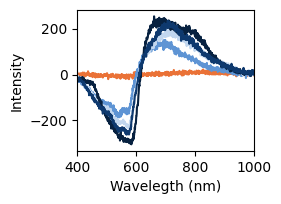

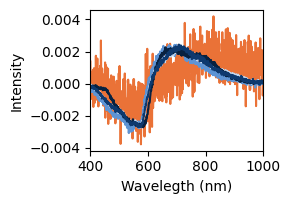

In [21]:
# plot spectra before and after normalization of 012-01

# np.random.seed(5)
# n = 10
# idxs = (np.random.randint(0, R_E.shape[0],n), np.random.randint(0, R_E.shape[1], n))

idxs = (np.array([73, 206, 189, 118, 400]), np.array([399, 158, 208, 7, 204])) # example pixel: (73,399)

color_list = [tum_red, tum_blue_light, tum_blue_light_2, tum_blue_dark, tum_blue_dark_2]

set_plotting_style("default")

fig, ax = plt.subplots(figsize=(2.54,2))
fig.tight_layout()
for x, y, color in zip(idxs[0], idxs[1], color_list):
    ax.plot(img.bands.centers, R_E[x,y,:], color=color)
ax.set_xlim([400, 1000])
ax.set_ylabel('Intensity')
ax.set_xlabel('Wavelegth (nm)')
# axs[0].set_title('Before normalization')
plt.savefig("../figures/projected_spectra_before_norm_helicoid_12-01.svg", format='svg', bbox_inches='tight')

R_E_norm = R_E/np.linalg.norm(R_E, axis=2, ord=1, keepdims=True)
fig, ax = plt.subplots(figsize=(2.5,2))
fig.tight_layout()
for x, y, color in zip(idxs[0], idxs[1], color_list):
    ax.plot(img.bands.centers, R_E_norm[x,y,:], color=color)
ax.set_xlim([400, 1000])
ax.set_ylabel('Intensity')
ax.set_xlabel('Wavelegth (nm)')
# ax.set_title('After normalization')
plt.savefig("../figures/projected_spectra_after_norm_helicoid_12-01.svg", format='svg', bbox_inches='tight')


